In [202]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from statistics import mean
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

In [182]:
data = pd.read_csv("training.csv", index_col = 0)

In [183]:
data.head()

,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,...,relative_well_position,batch_frac_classification,well_family_relationship,frac_type,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,OilPeakRate
0,1383493.751,717329.2368,1382854.564,712767.3700,1121,3963.582677,NaN,76000.0000,NaN,8712.598425,...,Standalone Well,Unknown,Standalone Well,Primary Frac,NaN,1383030.678,714796.3610,1382668.912,712798.4321,46.623023
1,1380344.035,711916.2732,1379738.429,707860.5643,1022,3179.133858,NaN,113000.0000,5.610964e+05,8627.952756,...,Outer Well,Unknown,Infill Child Well,Primary Frac,NaN,1379965.126,709541.7145,1379630.025,707907.6708,59.750009
2,1379915.895,717845.0063,1379274.644,713471.9952,1304,3810.039370,12.0,286571.4286,1.621424e+06,8801.181102,...,Standalone Well,Non-Batch Frac,Standalone Well,Primary Frac,92.0,1379357.250,715381.2327,1378960.372,713530.4490,10.785716
3,1383567.443,706640.2010,1382891.477,702068.3838,1022,3723.425197,11.0,106878.9286,4.377134e+05,8635.826772,...,Standalone Well,Unknown,Standalone Well,Primary Frac,NaN,1383099.610,704058.8508,1382727.299,702098.4882,123.797638
4,1378962.585,702623.9787,1379643.546,707204.9131,1022,3811.023622,NaN,112789.7143,6.229802e+05,8664.370079,...,Outer Well,Unknown,Infill Child Well,Primary Frac,NaN,1379546.414,705150.7519,1379987.487,707123.7258,102.309540


# Drop Sparse Columns

In [184]:
data = data.drop('number_of_stages', axis = 1)
data = data.drop('average_stage_length', axis = 1)
data = data.drop('average_proppant_per_stage', axis = 1)
data = data.drop('average_frac_fluid_per_stage', axis = 1)

# One-Hot Encoding

In [193]:
categoricals = data.select_dtypes('object')
cols = []
for categorical in categoricals:
    cols.append(categorical)
    unique_values = data[categorical].unique()
one_hot_encoded = pd.get_dummies(data, columns = cols)
one_hot_encoded.to_csv('encoded.csv', index = False)
one_hot_encoded

,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,...,batch_frac_classification_Batch-Sequential Frac,batch_frac_classification_Non-Batch Frac,batch_frac_classification_Unknown,well_family_relationship_Infill Child Well,well_family_relationship_Sibling Well,well_family_relationship_Standalone Well,well_family_relationship_Unknown,frac_type_Primary Frac,frac_type_Protection Frac,frac_type_Refrac
0,1383493.751,717329.2368,1382854.564,712767.3700,1121.0,3963.582677,13.44,76000.000000,6.534476e+05,8712.598425,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1380344.035,711916.2732,1379738.429,707860.5643,1022.0,3179.133858,13.16,113000.000000,5.610964e+05,8627.952756,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1379915.895,717845.0063,1379274.644,713471.9952,1304.0,3810.039370,12.00,286571.428600,1.621424e+06,8801.181102,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1383567.443,706640.2010,1382891.477,702068.3838,1022.0,3723.425197,11.00,106878.928600,4.377134e+05,8635.826772,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1378962.585,702623.9787,1379643.546,707204.9131,1022.0,3811.023622,13.44,112789.714300,6.229802e+05,8664.370079,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29687,1441088.593,978921.8705,1432758.032,979984.5869,1050.0,4167.460630,12.22,271687.539822,1.285663e+06,5504.674276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29688,1513299.189,976157.4486,1519890.072,975148.4820,1159.0,5340.196850,18.72,182266.297147,1.120019e+06,5204.619701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29689,1458652.142,972862.2346,1453129.889,973195.0998,1050.0,4728.090551,13.70,254559.282680,1.217470e+06,5395.929782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29690,1463417.436,972485.8276,1468807.765,971564.9743,1153.0,4850.334646,17.08,235684.904109,1.178785e+06,5306.642825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# NA Imputation

#### KNN

In [197]:
inf = np.isinf(one_hot_encoded)
inf_position = np.where(inf)
for row, col in zip(*inf_position):
    print(f"inf position: {row}, Column: {col}")
inf = np.isinf(one_hot_encoded)
one_hot_encoded[inf] = 0
second_max = one_hot_encoded['frac_fluid_to_proppant_ratio'].max()
print(second_max)
new_value = 400
one_hot_encoded.at[17862, 'frac_fluid_to_proppant_ratio'] = new_value
row_number = 17862
column_name = 'frac_fluid_to_proppant_ratio'  
value = one_hot_encoded.loc[one_hot_encoded.index[row_number], column_name]

400.0


In [198]:
imputer = KNNImputer(n_neighbors=50)
imputer.fit(one_hot_encoded)
trainingtrans = imputer.transform(one_hot_encoded)
training_imputed = pd.DataFrame(trainingtrans, columns=one_hot_encoded.columns)
training_imputed.to_csv('knn_imputed.csv', index=False)
training_imputed

,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,...,batch_frac_classification_Batch-Sequential Frac,batch_frac_classification_Non-Batch Frac,batch_frac_classification_Unknown,well_family_relationship_Infill Child Well,well_family_relationship_Sibling Well,well_family_relationship_Standalone Well,well_family_relationship_Unknown,frac_type_Primary Frac,frac_type_Protection Frac,frac_type_Refrac
0,1383493.751,717329.2368,1382854.564,712767.3700,1121.0,3963.582677,13.44,76000.000000,6.534476e+05,8712.598425,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1380344.035,711916.2732,1379738.429,707860.5643,1022.0,3179.133858,13.16,113000.000000,5.610964e+05,8627.952756,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1379915.895,717845.0063,1379274.644,713471.9952,1304.0,3810.039370,12.00,286571.428600,1.621424e+06,8801.181102,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1383567.443,706640.2010,1382891.477,702068.3838,1022.0,3723.425197,11.00,106878.928600,4.377134e+05,8635.826772,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1378962.585,702623.9787,1379643.546,707204.9131,1022.0,3811.023622,13.44,112789.714300,6.229802e+05,8664.370079,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29687,1441088.593,978921.8705,1432758.032,979984.5869,1050.0,4167.460630,12.22,271687.539822,1.285663e+06,5504.674276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29688,1513299.189,976157.4486,1519890.072,975148.4820,1159.0,5340.196850,18.72,182266.297147,1.120019e+06,5204.619701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29689,1458652.142,972862.2346,1453129.889,973195.0998,1050.0,4728.090551,13.70,254559.282680,1.217470e+06,5395.929782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29690,1463417.436,972485.8276,1468807.765,971564.9743,1153.0,4850.334646,17.08,235684.904109,1.178785e+06,5306.642825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Mean

In [310]:
#mean_imputed = one_hot_encoded.fillna(one_hot_encoded.mean())
#mean_imputed.to_csv('mean_imputed.csv', index=False)

# Scaling

In [200]:
scaler = StandardScaler()
scaler.fit(mean_imputed)
mean_imputed.to_csv('scaled.csv', index = False)

# Outlier Elimination

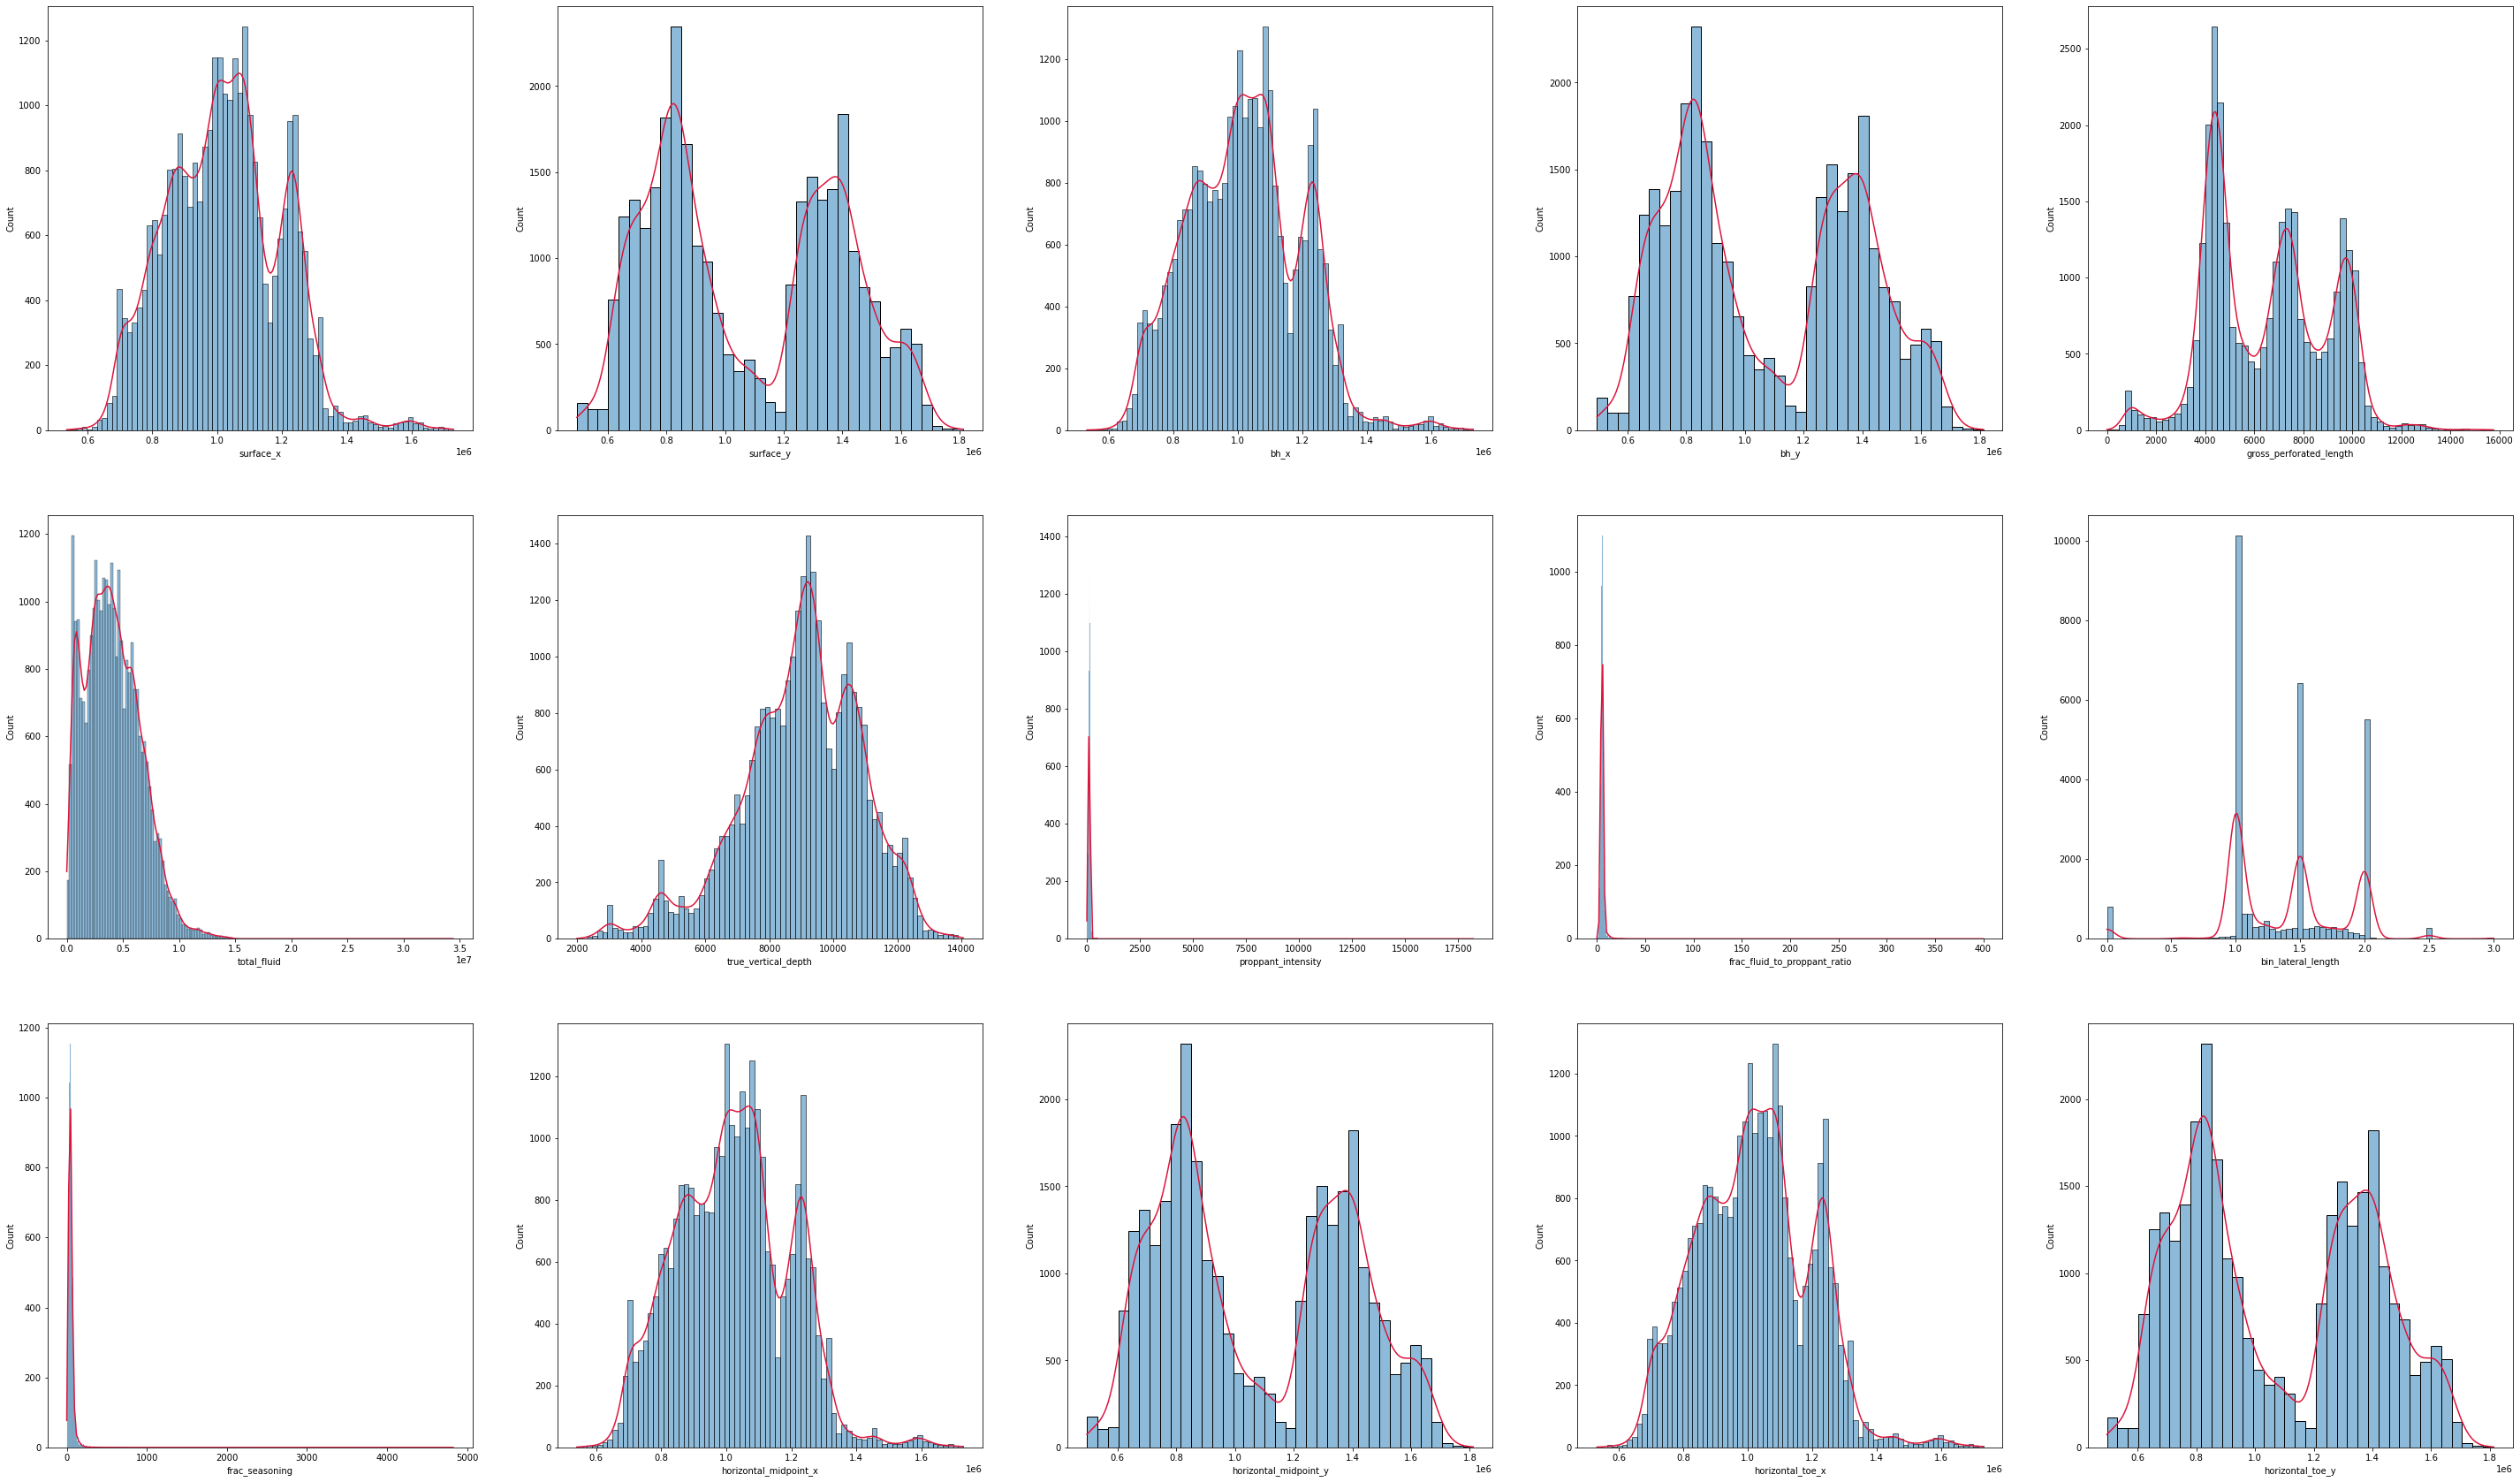

In [203]:
raw = pd.read_csv("scaled.csv")

plt.figure(figsize=(50,30))
plt.subplot(3,5,1)

ax=sns.histplot(raw['surface_x'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,2)

ax=sns.histplot(raw['surface_y'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,3)

ax=sns.histplot(raw['bh_x'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,4)

ax=sns.histplot(raw['bh_y'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,5)

ax=sns.histplot(raw['gross_perforated_length'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,6)

ax=sns.histplot(raw['total_fluid'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,7)

ax=sns.histplot(raw['true_vertical_depth'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,8)

ax=sns.histplot(raw['proppant_intensity'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,9)

ax=sns.histplot(raw['frac_fluid_to_proppant_ratio'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,10)

ax=sns.histplot(raw['bin_lateral_length'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,11)

ax=sns.histplot(raw['frac_seasoning'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,12)

ax=sns.histplot(raw['horizontal_midpoint_x'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,13)

ax=sns.histplot(raw['horizontal_midpoint_y'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,14)

ax=sns.histplot(raw['horizontal_toe_x'], kde=True)
ax.lines[0].set_color('crimson')
plt.subplot(3,5,15)

ax=sns.histplot(raw['horizontal_toe_y'], kde=True)
ax.lines[0].set_color('crimson')


plt.show()

In [288]:
raw['total_fluid_log'] = np.log(raw['total_fluid'])
raw['proppant_intensity_log'] = np.log(raw['proppant_intensity'])
raw['frac_fluid_to_proppant_ratio_log'] = np.log(raw['frac_fluid_to_proppant_ratio'])
raw['frac_seasoning_log'] = np.log(raw['frac_seasoning'])
raw.replace(-np.inf, 0, inplace=True)

C:\Users\wendy\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [289]:
# surface_x roughly follows normal distribution
mean = raw['surface_x'].mean()
sig  = raw['surface_x'].std()
lower = mean-3*sig
upper = mean+3*sig

outliers = (raw['surface_x']  < lower) | (raw['surface_x']  > upper)
# Remove outliers
df_filtered = raw[~outliers]

In [290]:
# surface_y
mean = df_filtered['surface_y'].mean()
sig  = df_filtered['surface_y'].std()
lower = mean-3*sig
upper = mean+3*sig

outliers = (df_filtered['surface_y']  < lower) | (df_filtered['surface_y']  > upper)
# Remove outliers
df_filtered1 = df_filtered[~outliers]

In [291]:
# bh_x
mean = df_filtered1['bh_x'].mean()
sig  = df_filtered1['bh_x'].std()
lower = mean-3*sig
upper = mean+3*sig
outliers = (df_filtered1['bh_x']  < lower) | (df_filtered1['bh_x']  > upper)
df_filtered2 = df_filtered1[~outliers]

In [292]:
# bh_y
mean = df_filtered2['bh_y'].mean()
sig  = df_filtered2['bh_y'].std()
lower = mean-3*sig
upper = mean+3*sig
outliers = (df_filtered2['bh_y']  < lower) | (df_filtered2['bh_y']  > upper)
df_filtered3 = df_filtered2[~outliers]

In [293]:
#gross_perforated_length
Q1 = np.percentile(df_filtered3['gross_perforated_length'], 25, method='midpoint')
Q3 = np.percentile(df_filtered3['gross_perforated_length'], 75, method='midpoint')
IQR = Q3 - Q1
upper = Q3+1.5*IQR
lower = Q1-1.5*IQR
outliers = (df_filtered3['gross_perforated_length']  < lower) | (df_filtered3['gross_perforated_length']  > upper)
df_filtered4 = df_filtered3[~outliers]

In [294]:
# total_fluid
Q1 = np.percentile(df_filtered4['total_fluid'], 25, method='midpoint')
Q3 = np.percentile(df_filtered4['total_fluid'], 75, method='midpoint')
IQR = Q3 - Q1
upper = Q3+1.5*IQR
lower = Q1-1.5*IQR
outliers = (df_filtered4['total_fluid']  < lower) | (df_filtered4['total_fluid']  > upper)
df_filtered5 = df_filtered4[~outliers]

In [295]:
# true_vertical_depth
mean = df_filtered5['true_vertical_depth'].mean()
sig  = df_filtered5['true_vertical_depth'].std()
lower = mean-3*sig
upper = mean+3*sig
outliers = (df_filtered5['true_vertical_depth']  < lower) | (df_filtered5['true_vertical_depth']  > upper)
df_filtered6 = df_filtered5[~outliers]

In [296]:
# proppant_intensity
Q1 = np.percentile(df_filtered6['proppant_intensity'], 25, method='midpoint')
Q3 = np.percentile(df_filtered6['proppant_intensity'], 75, method='midpoint')
IQR = Q3 - Q1
upper = Q3+1.5*IQR
lower = Q1-1.5*IQR
outliers = (df_filtered6['proppant_intensity']  < lower) | (df_filtered6['proppant_intensity']  > upper)
df_filtered7 = df_filtered6[~outliers]

In [297]:
# frac_fluid_to_proppant_ratio
Q1 = np.percentile(df_filtered7['frac_fluid_to_proppant_ratio'], 25, method='midpoint')
Q3 = np.percentile(df_filtered7['frac_fluid_to_proppant_ratio'], 75, method='midpoint')
IQR = Q3 - Q1
upper = Q3+1.5*IQR
lower = Q1-1.5*IQR
outliers = (df_filtered7['frac_fluid_to_proppant_ratio']  < lower) | (df_filtered7['frac_fluid_to_proppant_ratio']  > upper)
df_filtered8 = df_filtered7[~outliers]

In [298]:
# bin_lateral_length
mean = df_filtered8['bin_lateral_length'].mean()
sig  = df_filtered8['bin_lateral_length'].std()
lower = mean-3*sig
upper = mean+3*sig
outliers = (df_filtered8['bin_lateral_length']  < lower) | (df_filtered8['bin_lateral_length']  > upper)
df_filtered9 = df_filtered8[~outliers]

In [299]:
# frac_seasoning
Q1 = np.percentile(df_filtered9['frac_seasoning'], 25, method='midpoint')
Q3 = np.percentile(df_filtered9['frac_seasoning'], 75, method='midpoint')
IQR = Q3 - Q1
upper = Q3+1.5*IQR
lower = Q1-1.5*IQR
outliers = (df_filtered9['frac_seasoning']  < lower) | (df_filtered9['frac_seasoning']  > upper)
df_filtered10 = df_filtered9[~outliers]

In [300]:
# horizontal_midpoint_x

mean = df_filtered10['horizontal_midpoint_x'].mean()
sig  = df_filtered10['horizontal_midpoint_x'].std()
lower = mean-3*sig
upper = mean+3*sig
outliers = (df_filtered10['horizontal_midpoint_x']  < lower) | (df_filtered10['horizontal_midpoint_x']  > upper)
df_filtered11 = df_filtered10[~outliers]

In [301]:
# horizontal_midpoint_y

mean = df_filtered11['horizontal_midpoint_y'].mean()
sig  = df_filtered11['horizontal_midpoint_y'].std()
lower = mean-3*sig
upper = mean+3*sig
outliers = (df_filtered11['horizontal_midpoint_y']  < lower) | (df_filtered11['horizontal_midpoint_y']  > upper)
df_filtered12 = df_filtered11[~outliers]

In [302]:
# horizontal_toe_x
mean = df_filtered12['horizontal_toe_x'].mean()
sig  = df_filtered12['horizontal_toe_x'].std()
lower = mean-3*sig
upper = mean+3*sig
outliers = (df_filtered12['horizontal_toe_x']  < lower) | (df_filtered12['horizontal_toe_x']  > upper)
df_filtered13 = df_filtered12[~outliers]

In [303]:
# horizontal_toe_y
mean = df_filtered13['horizontal_toe_y'].mean()
sig  = df_filtered13['horizontal_toe_y'].std()
lower = mean-3*sig
upper = mean+3*sig
outliers = (df_filtered13['horizontal_toe_y']  < lower) | (df_filtered13['horizontal_toe_y']  > upper)
no_outliers= df_filtered13[~outliers]
no_outliers

,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,...,well_family_relationship_Sibling Well,well_family_relationship_Standalone Well,well_family_relationship_Unknown,frac_type_Primary Frac,frac_type_Protection Frac,frac_type_Refrac,total_fluid_log,proppant_intensity_log,frac_fluid_to_proppant_ratio_log,frac_seasoning_log
0,1383493.751,717329.2368,1382854.564,712767.3700,1121.0,3963.582677,13.44,76000.000000,6.534476e+05,8712.598425,...,0.0,1.0,0.0,1.0,0.0,0.0,13.390018,2.953585,1.815627,4.355939
1,1380344.035,711916.2732,1379738.429,707860.5643,1022.0,3179.133858,13.16,113000.000000,5.610964e+05,8627.952756,...,0.0,0.0,0.0,1.0,0.0,0.0,13.237648,3.570779,1.602505,3.545009
2,1379915.895,717845.0063,1379274.644,713471.9952,1304.0,3810.039370,12.00,286571.428600,1.621424e+06,8801.181102,...,0.0,1.0,0.0,1.0,0.0,0.0,14.298815,4.320348,1.733072,4.521789
3,1383567.443,706640.2010,1382891.477,702068.3838,1022.0,3723.425197,11.00,106878.928600,4.377134e+05,8635.826772,...,0.0,1.0,0.0,1.0,0.0,0.0,12.989320,3.357053,1.409868,3.251924
4,1378962.585,702623.9787,1379643.546,707204.9131,1022.0,3811.023622,13.44,112789.714300,6.229802e+05,8664.370079,...,0.0,0.0,0.0,1.0,0.0,0.0,13.342270,3.387627,1.708990,4.014941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29686,1458241.070,973266.6933,1463487.174,972372.2845,1153.0,4766.515748,16.28,239553.568394,1.213978e+06,5395.929782,...,0.0,0.0,0.0,1.0,0.0,0.0,14.009413,3.785378,1.810379,4.257030
29687,1441088.593,978921.8705,1432758.032,979984.5869,1050.0,4167.460630,12.22,271687.539822,1.285663e+06,5504.674276,...,0.0,0.0,0.0,1.0,0.0,0.0,14.066785,3.954044,1.701522,4.223324
29689,1458652.142,972862.2346,1453129.889,973195.0998,1050.0,4728.090551,13.70,254559.282680,1.217470e+06,5395.929782,...,0.0,0.0,0.0,1.0,0.0,0.0,14.012286,3.865287,1.780725,4.251063
29690,1463417.436,972485.8276,1468807.765,971564.9743,1153.0,4850.334646,17.08,235684.904109,1.178785e+06,5306.642825,...,0.0,0.0,0.0,1.0,0.0,0.0,13.979995,3.753012,1.842660,4.257030


In [304]:
no_outliers.to_csv('No_Outliers.csv', index = False)

# Interaction

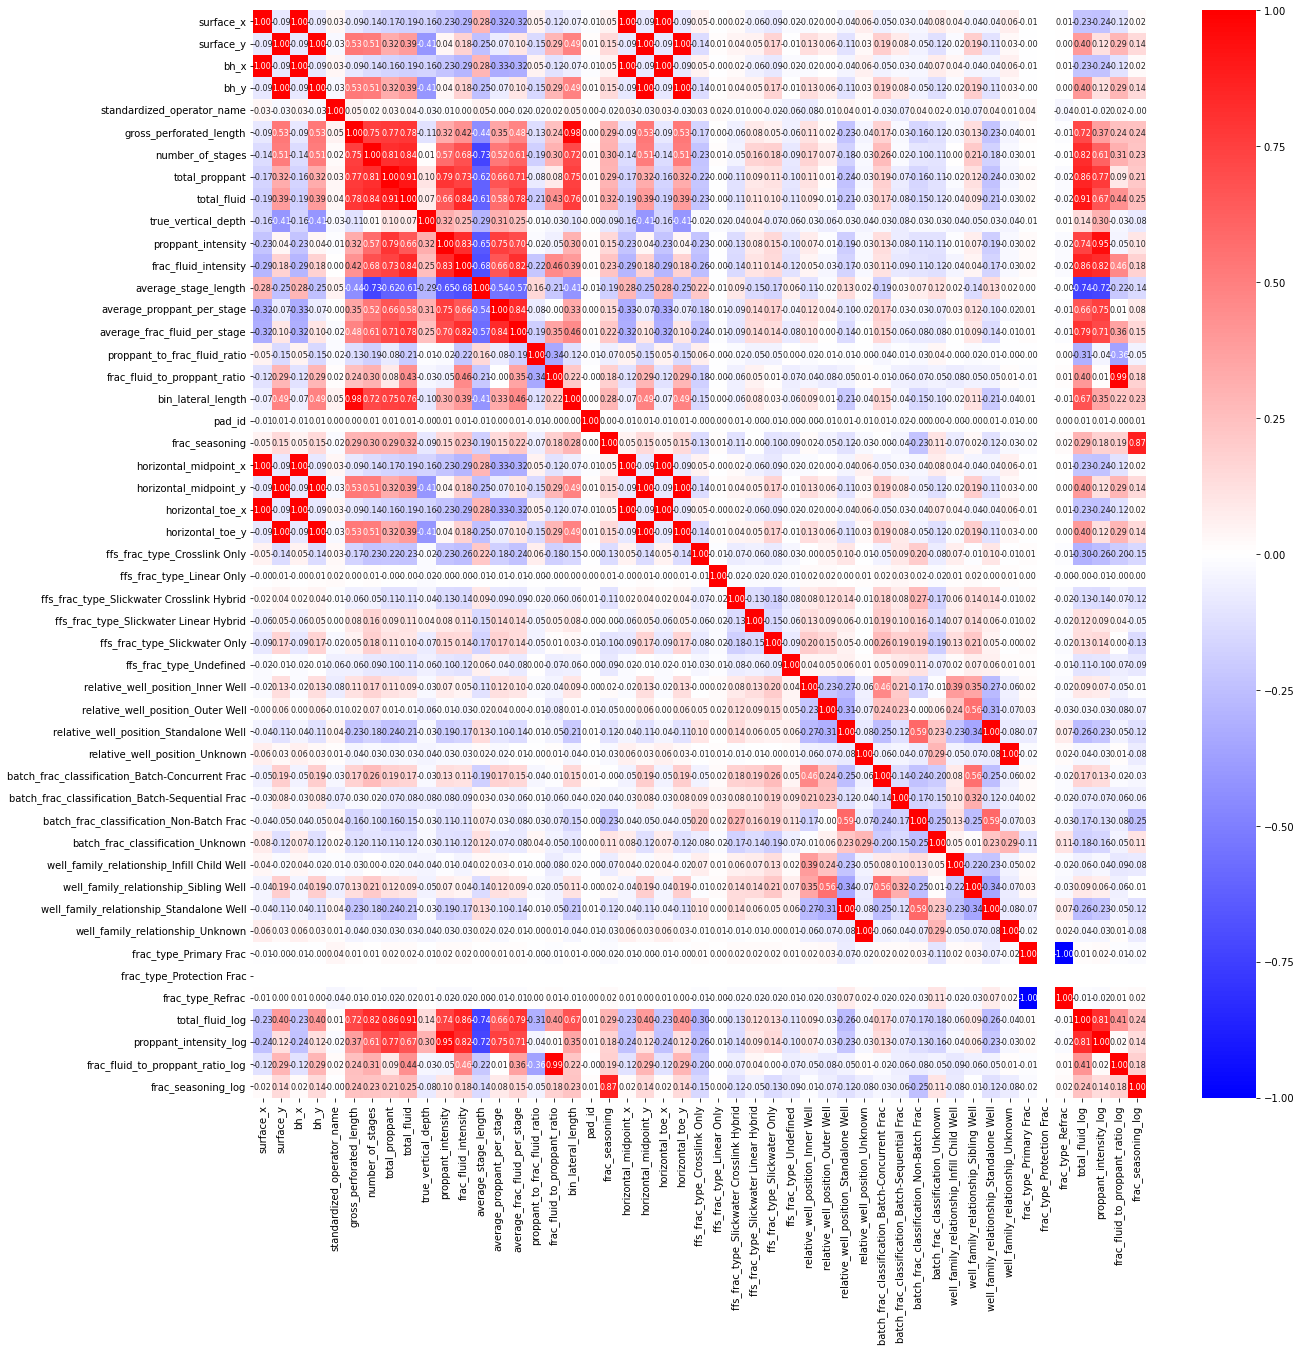

In [317]:
## Plot heatmap
exclude_y_df = data.drop(columns=['OilPeakRate']) # drop predict feature
corr_matrix = exclude_y_df.corr()
annot_kws = {"size": 8}
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='bwr', fmt=".2f", annot_kws=annot_kws)
plt.show()

## Create interactive terms
# Set threshold of correlation to filter desirable correlations
## Create interactive terms
# Set threshold of correlation to filter desirable correlations
threshold_roof = 0.5
exclude_terms = [
    'surface_x', 'surface_y', 'bh_x', 'bh_y', 'horizontal_toe_x', 'horizontal_toe_y',
    'frac_type_Protection Frac', 'horizontal_midpoint_y', 'horizontal_midpoint_x', 'frac_type_Refrac'
]

filtered_corr_matrix = corr_matrix[
    ((corr_matrix >= -threshold_roof) & (corr_matrix < 0)) | ((corr_matrix <= threshold_roof) & (corr_matrix > 0))]
correlation_pairs = []

# Find corrlation pairs in correlation interval
for i in range(len(filtered_corr_matrix)):
    for j in range(i+1, len(filtered_corr_matrix.columns)): # Only upper triangle
        if not pd.isna(filtered_corr_matrix.iloc[i, j]):
            correlation_pairs.append(
                (filtered_corr_matrix.index[i],
                 filtered_corr_matrix.columns[j],
                 filtered_corr_matrix.iloc[i, j]))

# Create new dataframe with only interactive terms
interaction_terms = {}

for pair in correlation_pairs:
    if pair[0] not in exclude_terms and pair[1] not in exclude_terms:
        interaction_term_name = f"{pair[0]}_CROSS_{pair[1]}"
        # Create the new interaction term by multiplying the two columns
        interaction_terms[interaction_term_name] = no_outliers[pair[0]] * no_outliers[pair[1]]

interaction_df = pd.DataFrame(interaction_terms)
combined_df = pd.concat([no_outliers, interaction_df], axis=1)

In [318]:
combined_df.to_csv('Interactions.csv', index = False)